## Импортим необходимые библиотеки

In [1]:
import json, re

from gensim.models import Word2Vec

from sklearn.feature_extraction.text import CountVectorizer

from keras.models import Model
from keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding, Input, Lambda
from keras.utils.vis_utils import plot_model
import keras.backend as K

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt

import tensorflow as tf

import numpy as np

from sklearn.neighbors import NearestNeighbors

embeddings_dim = 50

/home/alex/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/alex/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/alex/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Читаем вопросы из файла

In [2]:
q_data = []
with open('../data/main/trainmodel.json') as json_file:  
    q_data = json.load(json_file)
    
questions = []
for q in q_data:
    questions.append(re.sub('[!@#$?]', '', q["qText"]))

## Анализируем текстовые данные

In [3]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(questions)

sequences = tokenizer.texts_to_sequences(questions)
sequences_lenghts = np.array(list(map(lambda x: len(x), sequences)))

word_index = tokenizer.word_index
number_of_words = len(word_index)
print('{0} уникальных токенов.'.format(len(word_index)))

3172 уникальных токенов.


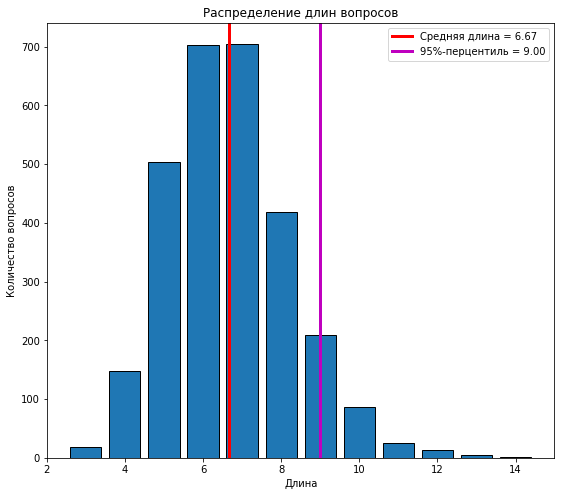

In [4]:
plt.figure(figsize=(20, 8))

plt.subplot(121)
plt.bar(*np.unique(sequences_lenghts, return_counts=True), edgecolor="k")
plt.axvline(np.mean(sequences_lenghts), 
            c="r", lw=3, 
            label="Средняя длина = {:.2f}".format(np.mean(sequences_lenghts)))
plt.axvline(np.percentile(sequences_lenghts, 95), 
            c="m", lw=3, 
            label="95%-перцентиль = {:.2f}".format(np.percentile(sequences_lenghts, 95)))
plt.xlabel("Длина")
plt.ylabel("Количество вопросов")
plt.title("Распределение длин вопросов")
plt.legend()

cut_length = np.round(np.percentile(sequences_lenghts, 95),0)

## Строим векторные представления вопросов

In [5]:
model = Word2Vec([q.split() for q in questions], size=embeddings_dim, window=10,min_count=1)
model.train([q.split() for q in questions],epochs=1000,total_examples=model.corpus_count)
model.most_similar("is")

/home/alex/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/alex/miniconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('was', 0.7051377296447754),
 ('are', 0.5893619060516357),
 ('does', 0.400970458984375),
 ('sith', 0.35755765438079834),
 ('revenge', 0.35489749908447266),
 ('did', 0.35324427485466003),
 ('wore', 0.34757810831069946),
 ('plays', 0.34129276871681213),
 ('twice', 0.33817264437675476),
 ('suit', 0.33579927682876587)]

In [6]:
q_vectors = pad_sequences(sequences, maxlen=int(cut_length))
print('Размерность тренировочных данных:', q_vectors.shape)

Размерность тренировочных данных: (2834, 9)


In [7]:
embedding_matrix = np.zeros((len(word_index) + 1, embeddings_dim))
for word, i in word_index.items():
    if word in model.wv.vocab:
        embedding_matrix[i] = model[word]

/home/alex/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


## Анализируем графовые данные

In [8]:
data = ''
with open('../data/d-freebase-rp/trainmodel.json') as json_file:  
    data = json.load(json_file)

In [9]:
rels = []
for q in data:
    q_rels = ""
    for paths in q['relPaths']:
        for rel in paths[0]:
            q_rels+= rel+" "
    rels.append(str(q_rels))

In [10]:
countVec = CountVectorizer(token_pattern=r"[^\s]*")
path_vectors = countVec.fit_transform(rels)
n_unique_relations = len(countVec.vocabulary_)
print("Количество уникальных связей = {0}".format(n_unique_relations))
print("Размерность матрицы связей = {0}".format(path_vectors.shape))

Количество уникальных связей = 633
Размерность матрицы связей = (2834, 633)


## Строим модель

In [11]:
q1_input = Input(shape=(cut_length,), 
                dtype="int32", 
                name="QInput")

aPath_input = Input(shape=(n_unique_relations,), 
                dtype="float32", 
                name="AInput")

In [12]:
_embedding_layer = Embedding(input_dim=number_of_words + 1,
                             output_dim=embeddings_dim,
                             input_length=cut_length,
                             weights=[embedding_matrix],
                             trainable=True,
                             mask_zero=False, 
                             name="Embedding")
_conv1d_layer = Conv1D(embeddings_dim,
                       5,
                       activation='relu')

_maxpool1d_layer = GlobalMaxPooling1D()

_dense_layer = Dense(embeddings_dim, input_dim=n_unique_relations+1, activation='relu')

In [13]:
q1_embedding = _embedding_layer(q1_input)
q1_conv = _conv1d_layer(q1_embedding)
q1_maxpool = _maxpool1d_layer(q1_conv)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [14]:
aPath_dense = _dense_layer(aPath_input)

In [15]:
def L2_norm(x):
    return K.l2_normalize(x, axis=1)

In [16]:
q1_normalized = Lambda(function=L2_norm, name="QL2norm")(q1_maxpool)
aPath_normalized = Lambda(function=L2_norm, name="AL2norm")(aPath_dense)

In [17]:
def triplet_loss(args):
    
    q, a = args
    
    def _get_probs():
        # easy negative sampling, i.e. take random from batch
        batch_size = tf.shape(a)[0]
        probs = tf.ones((batch_size, batch_size)) - tf.eye(batch_size, batch_size)
        return probs
    
    def _get_distance(batch1, batch2):
        return 1 - tf.reduce_sum(tf.multiply(batch1, batch2), axis=1)
    
    # margin
    alpha = 0.2
    
    # negative sampling
    probs = _get_probs()
    probs /= tf.reduce_sum(probs, axis=1)
    
    negative_idxs = tf.multinomial(tf.log(probs), 1)
    negs = tf.gather(a, negative_idxs)[:, 0]
    
    # distance calculation
    Dn = _get_distance(q, negs)
    Dp = _get_distance(q, a)
    
    # loss
    loss = tf.reduce_mean(tf.maximum(0.0, Dp - Dn + alpha))
    
    return loss

In [18]:
loss_layer = Lambda(function=triplet_loss, name="Loss")([q1_normalized, aPath_normalized])

In [19]:
model = Model(inputs=[q1_input, aPath_input], outputs=[loss_layer])

In [20]:
def dummy_loss(y_true, y_pred):
    return y_pred

In [21]:
model.compile(loss=dummy_loss, optimizer="Adam")
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
QInput (InputLayer)             (None, 9.0)          0                                            
__________________________________________________________________________________________________
Embedding (Embedding)           (None, 9.0, 50)      158650      QInput[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 5.0, 50)      12550       Embedding[0][0]                  
__________________________________________________________________________________________________
AInput (InputLayer)             (None, 633)          0                                            
__________________________________________________________________________________________________
global_max

In [22]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Обучаем модель

In [35]:
hist = model.fit([q_vectors, path_vectors],np.zeros(q_vectors.shape[0]),
                 epochs=25, batch_size=64)

Epoch 1/25
2834/2834 [==============================] - 0s 150us/step - loss: 0.0144
Epoch 2/25
2834/2834 [==============================] - 0s 141us/step - loss: 0.0158
Epoch 3/25
2834/2834 [==============================] - 0s 143us/step - loss: 0.0152
Epoch 4/25
2834/2834 [==============================] - 0s 140us/step - loss: 0.0147
Epoch 5/25
2834/2834 [==============================] - 0s 139us/step - loss: 0.0139
Epoch 6/25
2834/2834 [==============================] - 0s 145us/step - loss: 0.0139
Epoch 7/25
2834/2834 [==============================] - 0s 135us/step - loss: 0.0133
Epoch 8/25
2834/2834 [==============================] - 0s 139us/step - loss: 0.0138
Epoch 9/25
2834/2834 [==============================] - 0s 140us/step - loss: 0.0124
Epoch 10/25
2834/2834 [==============================] - 0s 139us/step - loss: 0.0112
Epoch 11/25
2834/2834 [==============================] - 0s 143us/step - loss: 0.0111
Epoch 12/25
2834/2834 [==============================] - 0s 143

In [36]:
q_model = Model(inputs=[model.get_layer("QInput").input], 
                outputs=[model.get_layer("QL2norm").output])

aPath_model = Model(inputs=[model.get_layer("AInput").input], 
                outputs=[model.get_layer("AL2norm").output])

In [37]:
answers_predicted = aPath_model.predict(path_vectors)
questions_predicted = q_model.predict(q_vectors)

In [38]:
knn = NearestNeighbors(n_neighbors=5, 
                 metric="minkowski", 
                 p=2, 
                 n_jobs=-1, 
                 algorithm="kd_tree")
knn.fit(answers_predicted)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=-1, n_neighbors=5, p=2, radius=1.0)

In [50]:
knn.kneighbors(np.array([questions_predicted[10]]), n_neighbors=5)

(array([[0.58197917, 0.58197917, 0.58197917, 0.58197917, 0.58197917]]),
 array([[ 660, 2769,   10,  272, 2143]]))

In [49]:
questions[10]

'which countries border the us'

In [51]:
rels[660]

'/location/location/adjoin_s /location/adjoining_relationship/adjoins '